## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !cat ml-1m/README

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, np.int64(3009))

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    result[list(set(range(result.columns.max() + 1)) - set(result.columns))] = 0.0
    return result[list(range(result.columns.max()+1))].to_numpy()

In [10]:
interactions = df_to_matrix(df_train) 

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    users = df['user_id'].values
    items = df['item_id'].values
    ratings = df['rating'].values
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    return coo_array((ratings, (users, items)), shape=(n_users, n_items))

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from scipy.sparse.linalg import svds

def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)


    if isinstance(interactions, np.ndarray):
        U, S, Vt = np.linalg.svd(interactions, full_matrices=False)
        k = len(S) if n_singular_values == -1 else min(n_singular_values, len(S))
        S_diag = np.diag(S[:k])
        return U[:, :k], S_diag, Vt[:k, :]
    else:
        m, n = interactions.shape
        max_k = min(m, n)
        k = max_k if n_singular_values == -1 else min(n_singular_values, max_k)
        k = min(k, max_k - 1) if max_k > 1 else 1
        U, S, Vt = svds(interactions, k=k)
        S = S[::-1]
        U = U[:, ::-1]
        Vt = Vt[::-1, :]
        S_diag = np.diag(S)
        return U, S_diag, Vt

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values)
    reconstructed = U @ S @ V

    if isinstance(interactions, np.ndarray):
        interacted_mask = (interactions != 0)
    else:
        interacted_mask = interactions.toarray().astype(bool)
    scores = np.where(interacted_mask, -np.inf, reconstructed)
    recommendations = np.argsort(-scores, axis=1)[:, :top_k]

    return recommendations

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [19]:
from sklearn.metrics import ndcg_score


def calculate_ndcg(test_df, recommendations, k=100):
    test_matrix = df_to_matrix(test_df)
    relevance = test_matrix > 0
    recommendations = recommendations[df_test.user_id.unique()]
    dence_recommendations = np.zeros_like(test_matrix)
    for i in range(test_matrix.shape[0]):
        dence_recommendations[i, recommendations[i]] = 1.0
    
    return ndcg_score(relevance, dence_recommendations, k=k)

In [20]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score


def plot_graphs(interactions: Union[np.ndarray, coo_array], top_k: int = 100):
    n_singular_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    time_log = []

    for n_singular in n_singular_list:
        start_time = time.time()
        recs = make_svd_recommendations(interactions, n_singular, top_k)
        elapsed = time.time() - start_time
        time_log.append(elapsed)
        _ndcg = calculate_ndcg(df_test, recs)
        ndcg_scores.append(_ndcg)
        print(f"n_singular={n_singular}, NDCG={ndcg_scores[-1]:.3f}, Time={elapsed:.2f}s")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_singular_list, ndcg_scores, marker='o', linestyle='--', color='b')
    plt.title('NDCG@100 vs. Singular Values')
    plt.xlabel('Number of Singular Values')
    plt.ylabel('NDCG')
    plt.xscale('log')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(n_singular_list, time_log, marker='o', linestyle='--', color='r')
    plt.title('Computation Time vs. Singular Values')
    plt.xlabel('Number of Singular Values')
    plt.ylabel('Time (s)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


n_singular=1, NDCG=0.214, Time=28.13s
n_singular=10, NDCG=0.241, Time=27.98s
n_singular=50, NDCG=0.221, Time=28.64s
n_singular=200, NDCG=0.173, Time=28.25s
n_singular=1000, NDCG=0.065, Time=28.70s


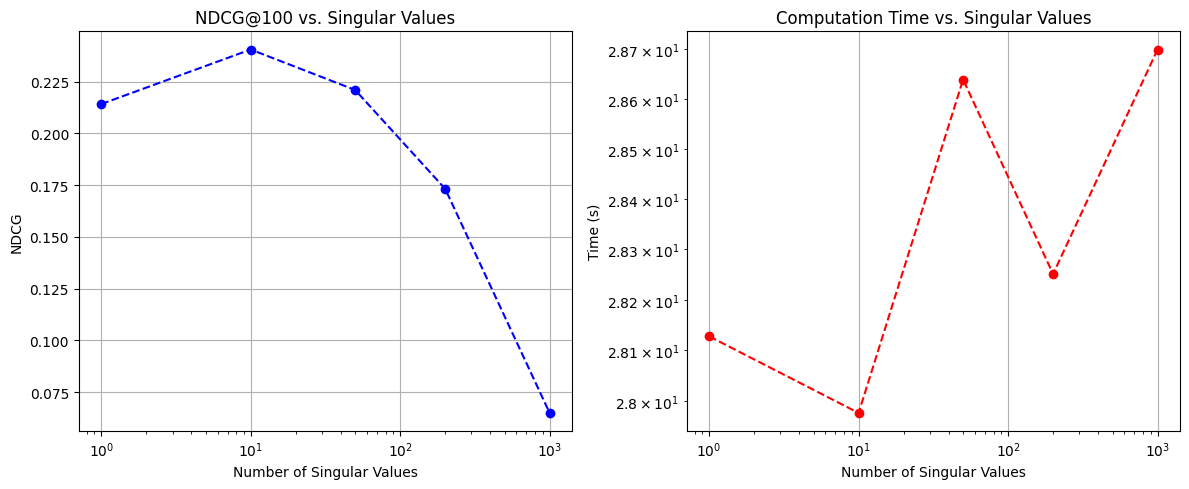

In [21]:
plot_graphs(interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [22]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import numpy as np


def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if isinstance(interactions, np.ndarray):
        csr_interactions = csr_matrix(interactions)
    elif isinstance(interactions, coo_array):
        csr_interactions = interactions.tocsr()
    else:
        raise TypeError("interactions must be np.ndarray or coo_array")
    
    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=50,
        random_state=42
    )

    model.fit(csr_interactions * alpha)

    user_ids = np.arange(csr_interactions.shape[0])
    recs, _ = model.recommend(
        userid=user_ids,
        user_items=csr_interactions,
        N=top_k,
        filter_already_liked_items=True
    )

    return recs

/workspaces/ML_RecSys/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
als_recs = make_als_recommendations(interactions, n_factors=50, alpha=40, regularization=0.1)
svd_recs = make_svd_recommendations(coo_interactions, 100)

print("ALS NDCG:", calculate_ndcg(df_test, als_recs))
print("SVD NDCG:", calculate_ndcg(df_test, svd_recs))

/workspaces/ML_RecSys/.conda/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [00:14<00:00,  3.33it/s]


ALS NDCG: 0.18321326891912362
SVD NDCG: 0.20362154910788785


In [ ]:
best_ndcg = 0
best_params = {}

for factors in [50, 100, 200]:
    for alpha in [1, 10, 40]:
        for reg in [0.01, 0.1, 1.0]:
            recs = make_als_recommendations(
                interactions,
                n_factors=factors,
                alpha=alpha,
                regularization=reg
            )
            current_ndcg = calculate_ndcg(df_test, recs)

            if current_ndcg > best_ndcg:
                best_ndcg = current_ndcg
                best_params = {
                    'factors': factors,
                    'alpha': alpha,
                    'regularization': reg
                }

print(f"Best NDCG: {best_ndcg:.4f}, Params: {best_params}")

100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


 58%|█████▊    | 29/50 [00:42<00:27,  1.33s/it]

In [ ]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [ ]:
movies = pd.read_csv(
    "ml-1m/movies.dat", 
    sep="::", 
    names=["item_id", "title", "genres"], 
    encoding="latin1",
    engine="python"
)
item_id_to_title = movies.set_index("item_id")["title"].to_dict()

In [ ]:
original_item_ids = movies["item_id"].unique()

In [ ]:
item_le.fit(original_item_ids)

LabelEncoder()

In [ ]:
def explain_recommendations(
    user_id: int,
    model: AlternatingLeastSquares,
    interactions: csr_matrix,
    item_id_to_title: dict,
    top_n_recommendations: int = 3,
    top_n_contributions: int = 5
):
    recommended_items, _ = model.recommend(
        userid=[user_id],
        user_items=interactions[user_id],
        N=top_n_recommendations,
        filter_already_liked_items=True
    )

    user_history = interactions[user_id].indices
    history = [
        item_id_to_title[item_le.inverse_transform([i])[0]] 
        for i in user_history
    ]

    explanations = []
    for item_idx in recommended_items[0]:
        total_score, contributions, _ = model.explain(
            userid=user_id,
            user_items=interactions,
            itemid=item_idx,
            N=top_n_contributions
        )

        contribution_details = []
        for contrib_item_idx, score in contributions:
            original_id = item_le.inverse_transform([contrib_item_idx])[0]
            contribution_details.append({
                "title": item_id_to_title[original_id],
                "score": float(score)
            })

        original_item_id = item_le.inverse_transform([item_idx])[0]
        explanations.append({
            "recommended_movie": item_id_to_title[original_item_id],
            "score": float(total_score),
            "contributions": contribution_details
        })

    return history, explanations

In [ ]:
user_ids = [42, 100, 777]

for user_id in user_ids:
    history, explanations = explain_recommendations(user_id, model, csr_interactions, item_id_to_title)

    print(f"=== Пользователь {user_id} ===")
    print("\nИстория просмотров:")
    for movie in history[:5]:
        print(f"- {movie}")

    print("\nОбъяснения рекомендаций:")
    for exp in explanations:
        print(f"\nРекомендация: {exp['recommended_movie']} (общий скор: {exp['score']:.2f})")
        print("Вклад айтемов:")
        for contrib in exp['contributions']:
            print(f"- {contrib['title']}: {contrib['score']:.2f}")

=== Пользователь 42 ===

История просмотров:
- Toy Story (1995)
- GoldenEye (1995)
- Get Shorty (1995)
- Twelve Monkeys (1995)
- Pocahontas (1995)

Объяснения рекомендаций:

Рекомендация: Your Friends and Neighbors (1998) (общий скор: 0.68)
Вклад айтемов:
- Pet Sematary II (1992): 0.04
- Beavis and Butt-head Do America (1996): 0.03
- Character (Karakter) (1997): 0.03
- Three Colors: White (1994): 0.03
- Splash (1984): 0.03

Рекомендация: Beyond Silence (1996) (общий скор: 0.75)
Вклад айтемов:
- Rock, The (1996): 0.03
- King and I, The (1999): 0.03
- Atlantic City (1980): 0.02
- Character (Karakter) (1997): 0.02
- Velvet Goldmine (1998): 0.02

Рекомендация: 10 Things I Hate About You (1999) (общий скор: 0.68)
Вклад айтемов:
- Jules and Jim (Jules et Jim) (1961): 0.05
- Illuminata (1998): 0.05
- Iron Eagle II (1988): 0.05
- Idle Hands (1999): 0.03
- Inspector General, The (1949): 0.03
=== Пользователь 100 ===

История просмотров:
- Toy Story (1995)
- Grumpier Old Men (1995)
- Sabrina (19

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [ ]:
from scipy.sparse import coo_matrix


def transform_binary_all(ratings: np.ndarray) -> np.ndarray:
    return np.where(ratings != 0, 1, 0)

def transform_binary_4plus(ratings: np.ndarray) -> np.ndarray:
    return np.where(ratings >= 4, 1, 0)

def transform_signed(ratings: np.ndarray) -> np.ndarray:
    return np.where(ratings >= 4, 1, -1)

def transform_signed_time_decay(df: pd.DataFrame, decay_rate: float = 0.1) -> np.ndarray:
    _signed = np.where(df["rating"] >= 4, 1, -1)

    max_time = df["datetime"].max()
    delta_days = (max_time - df["datetime"]).dt.days
    decay = np.exp(-decay_rate * delta_days)

    return _signed * decay


In [ ]:
results = {}

# 1
df_train_binary_all = df_train.copy()
df_train_binary_all['rating'] = transform_binary_all(df_train["rating"].values)
interactions_binary_all = df_to_matrix(df_train_binary_all)
coo_interactions_binary_all = df_to_coo(df_train_binary_all)

svd_recs = make_svd_recommendations(coo_interactions_binary_all, 100)
results["binary_all_svd"] = calculate_ndcg(df_test, svd_recs)
als_recs = make_als_recommendations(interactions_binary_all, alpha=1.0)
results["binary_all_als"] = calculate_ndcg(df_test, als_recs)

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


In [ ]:
# 2
df_train_binary_4plus = df_train.copy()
df_train_binary_4plus['rating'] = transform_binary_4plus(df_train["rating"].values)
interactions_binary_4plus = df_to_matrix(df_train_binary_4plus)
coo_interactions_binary_4plus = df_to_coo(df_train_binary_4plus)

svd_recs = make_svd_recommendations(coo_interactions_binary_4plus, 100)
results["binary_4plus_svd"] = calculate_ndcg(df_test, svd_recs)
als_recs = make_als_recommendations(interactions_binary_4plus, alpha=1.0)
results["binary_4plus_als"] = calculate_ndcg(df_test, als_recs)

100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


In [ ]:
# 3
df_train_signed = df_train.copy()
df_train_signed['rating'] = transform_signed(df_train["rating"].values)
interactions_signed = df_to_matrix(df_train_signed)
coo_interactions_signed = df_to_coo(df_train_signed)

svd_recs = make_svd_recommendations(coo_interactions_signed, 100)
results["binary_signed_svd"] = calculate_ndcg(df_test, svd_recs)
als_recs = make_als_recommendations(interactions_signed, alpha=1.0)
results["binary_signed_als"] = calculate_ndcg(df_test, als_recs)

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


In [ ]:
# 4
df_train_signed_time_decay = df_train.copy()
df_train_signed_time_decay['rating'] = transform_signed_time_decay(df_train)
interactions_signed_time_decay = df_to_matrix(df_train_signed_time_decay)
coo_interactions_signed_time_decay = df_to_coo(df_train_signed_time_decay)

svd_recs = make_svd_recommendations(coo_interactions_signed_time_decay, 100)
results["binary_signed_time_decay_svd"] = calculate_ndcg(df_test, svd_recs)
als_recs = make_als_recommendations(interactions_signed_time_decay, alpha=1.0)
results["binary_signed_time_decay_als"] = calculate_ndcg(df_test, als_recs)

100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


In [ ]:
results

{'binary_all_svd': np.float64(0.20362154910788785),
 'binary_all_als': np.float64(0.1998446346764113),
 'binary_4plus_svd': np.float64(0.15449271672967502),
 'binary_4plus_als': np.float64(0.17397993921169447),
 'binary_signed_svd': np.float64(0.20362154910788785),
 'binary_signed_als': np.float64(0.2009492547929859),
 'binary_signed_time_decay_svd': np.float64(0.20362154910788785),
 'binary_signed_time_decay_als': np.float64(0.1912349435987662)}

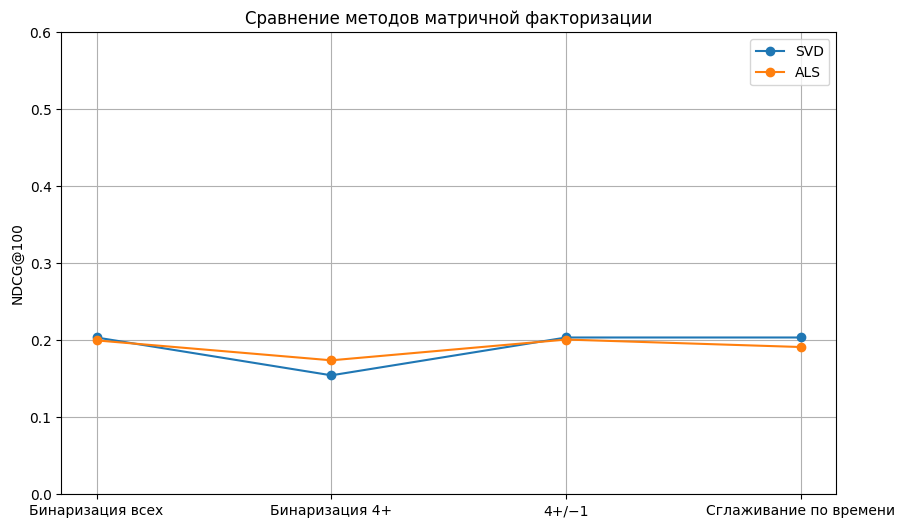

In [ ]:
transformations = ["Бинаризация всех", "Бинаризация 4+", "4+/−1", "Сглаживание по времени"]
svd_scores = [0.20362154910788785, 0.15449271672967502, 0.20362154910788785, 0.20362154910788785]
als_scores = [0.1998446346764113, 0.17397993921169447, 0.2009492547929859, 0.1912349435987662]

plt.figure(figsize=(10, 6))
plt.plot(transformations, svd_scores, marker="o", label="SVD")
plt.plot(transformations, als_scores, marker="o", label="ALS")
plt.title("Сравнение методов матричной факторизации")
plt.ylabel("NDCG@100")
plt.ylim(0, 0.6)
plt.legend()
plt.grid(True)
plt.show()

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def _init_(self, n_factors=100, alpha=1.0, reg=0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg = reg
        self.user_factors = None
        self.item_factors = None

    def _init_factors(self, n_users, n_items):
        self.user_factors = np.random.normal(
            scale=1/np.sqrt(self.n_factors), 
            size=(n_users, self.n_factors)
        )
        self.item_factors = np.random.normal(
            scale=1/np.sqrt(self.n_factors), 
            size=(n_items, self.n_factors)
        )

    def fit(self, interactions: coo_matrix, n_iters=10):
        n_users, n_items = interactions.shape
        self._init_factors(n_users, n_items)

        for _ in range(n_iters):
            self._update_users(interactions)
            self._update_items(interactions)

    def _update_users(self, interactions: coo_matrix):
        n_users = interactions.shape[0]
        for u in range(n_users):
            items = interactions.row == u
            if not np.any(items):
                continue
            item_indices = interactions.col[items]
            A = self.item_factors[item_indices]
            b = np.ones(len(item_indices)) * self.alpha
            lambda_eye = self.reg * np.eye(self.n_factors)
            self.user_factors[u] = np.linalg.solve(A.T @ A + lambda_eye, A.T @ b)

    def _update_items(self, interactions: coo_matrix):
        n_items = interactions.shape[1]
        for i in range(n_items):
            users = interactions.col == i
            if not np.any(users):
                continue
            user_indices = interactions.row[users]
            A = self.user_factors[user_indices]
            b = np.ones(len(user_indices)) * self.alpha
            lambda_eye = self.reg * np.eye(self.n_factors)
            self.item_factors[i] = np.linalg.solve(A.T @ A + lambda_eye, A.T @ b)

    def predict(self, user_ids: np.ndarray, top_k=100):
        scores = self.user_factors[user_ids] @ self.item_factors.T
        return np.argsort(-scores, axis=1)[:, :top_k]

In [ ]:
model = iALS(n_factors=50, alpha=40, reg=0.1)
model.fit(coo_interactions, n_iters=10)

In [ ]:
recs = model.predict(df_train.user_id.unique(), top_k=100)

ndcg = calculate_ndcg(df_test, recs)
print(f"NDCG@100: {ndcg:.4f}")

NDCG@100: 0.0526
